In [1]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
import math
ot.RandomGenerator.SetSeed(42)

# ======================================== Fonction de plot ========================================
def plot_field(field, mode="plot", ax=None, title=None, vmin=None, vmax=None, add_colorbar=True):
    mesh = field.getMesh()

    x = mesh.getVertices().getMarginal(0)
    y = mesh.getVertices().getMarginal(1)
    z = field.getValues()

    x_unique = np.unique(x)
    y_unique = np.unique(y)
    nx = len(x_unique)
    ny = len(y_unique)

    X = np.array(x).reshape(ny, nx)
    Y = np.array(y).reshape(ny, nx)
    Z = np.array(z).reshape(ny, nx)

    if mode == "plot":
        fig, ax_local = plt.subplots(figsize=(6, 4))
    elif mode == "subplot":
        if ax is None:
            raise ValueError("En mode 'subplot', fournir un axe via le paramètre ax.")
        fig, ax_local = ax.figure, ax
    else:
        raise ValueError("mode doit être 'plot' ou 'subplot'.")

    contour = ax_local.contourf(X, Y, Z, levels=15, vmin=vmin, vmax=vmax)
    if add_colorbar:
        fig.colorbar(contour, ax=ax_local)
    if title:
        ax_local.set_title(title)

    return fig, ax_local, contour


# ======================== Maillage & Transformation par sigmoïde ========================
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))
sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)


### Tests de différents hyperparamètres

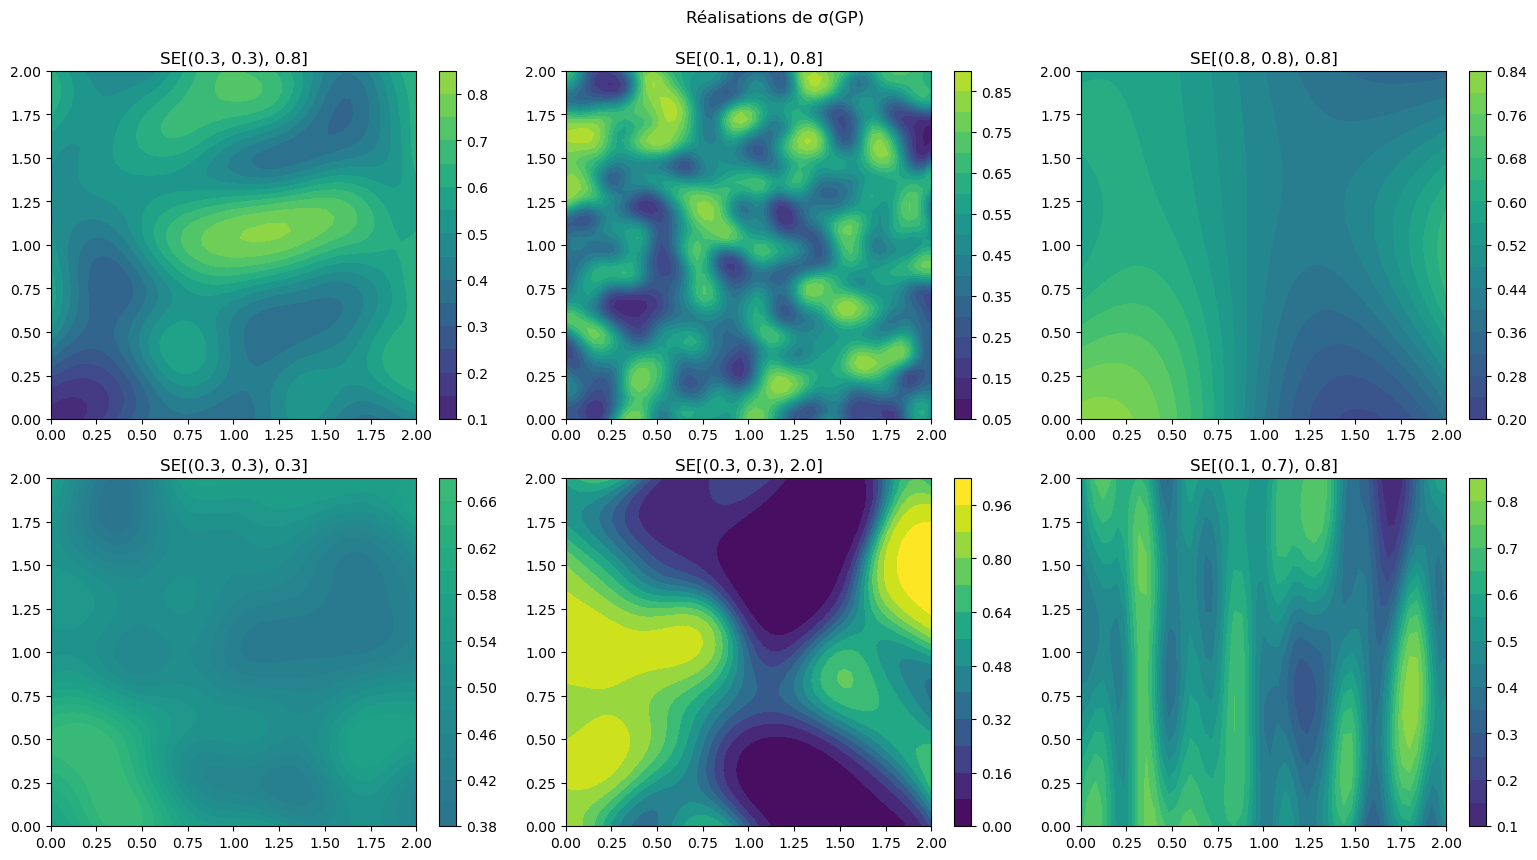

In [2]:
# Grille d'hyperparamètres du noyau SE : ([lx, ly], amplitude)
param_grid = [
    ([0.3, 0.3], 0.8),    # référence
    ([0.1, 0.1], 0.8),    # plus rugeux
    ([0.8, 0.8], 0.8),    # plus lisse
    ([0.3, 0.3], 0.3),    # amplitude plus faible
    ([0.3, 0.3], 2.0),    # amplitude plus forte
    ([0.1, 0.7], 0.8),    # anisotrope
]

fields = []
for scales, amp in param_grid:
    cov = ot.SquaredExponential(scales, [amp])
    gp = ot.GaussianProcess(cov, mesh)
    process = ot.CompositeProcess(field_function, gp)
    fields.append((process.getRealization(), scales, amp))

# Bornes de couleurs communes pour comparaison cohérente
all_vals = np.concatenate([np.array(f[0].getValues()).ravel() for f in fields])
zmin, zmax = float(np.min(all_vals)), float(np.max(all_vals))

# Grille de subplots
n = len(fields)
ncols = min(3, n)
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 4.3*nrows), squeeze=False)
axes_flat = axes.ravel()

for i, (field_f, scales, amp) in enumerate(fields):
    fig, ax_i, _ = plot_field(
        field_f,
        mode="subplot",
        ax=axes_flat[i],
        title=f"SE[({scales[0]}, {scales[1]}), {amp}]",
        vmin=zmin, vmax=zmax,
        add_colorbar=True
    )

# Masquer axes inutilisés
for ax in axes_flat[n:]:
    ax.axis('off')

fig.suptitle("Réalisations de σ(GP)", y=0.995)
plt.tight_layout()
plt.show()


(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x307f5e840>)

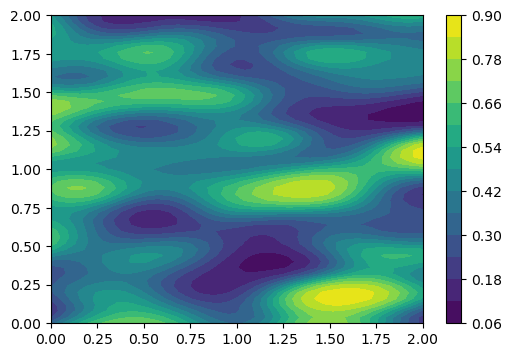

In [3]:
# Create mesh 
mesher = ot.IntervalMesher([50, 50]) 
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0])) 

cov = ot.SquaredExponential([0.35, 0.12], [1.0]) 
X = ot.GaussianProcess(cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))']) 
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid) 
process = ot.CompositeProcess(field_function, X) 

# Plot a realization of the composite process 
field_f = process.getRealization() 
plot_field(field_f)

In [4]:
cov

class=SquaredExponential scale=class=Point name=Unnamed dimension=2 values=[0.35,0.12] amplitude=class=Point name=Unnamed dimension=1 values=[1]

In [5]:
import openturns as ot

covModel = ot.SquaredExponential(2)
t = [0.2, 0.4]
s = [0.2, 0.4]
print(covModel(s, t))


[[ 1 ]]


In [6]:
covModel.getFullParameter

<bound method CovarianceModelImplementation.getFullParameter of class=SquaredExponential scale=class=Point name=Unnamed dimension=2 values=[1,1] amplitude=class=Point name=Unnamed dimension=1 values=[1]>

### Ajout d'une moyenne dans le GP

(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x326c1c2c0>)

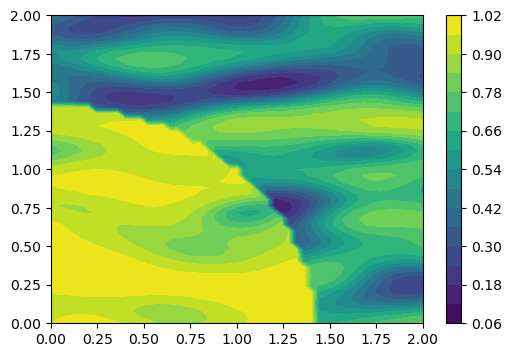

In [7]:
# Create mesh
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))

def tend(X):
    return [3*(X[0]**2 + X[1]**2 <= 2.0)]

f = ot.PythonFunction(2, 1, tend)
fTrend = ot.TrendTransform(f, mesh)

cov = ot.SquaredExponential([0.35, 0.12], [1.0])
X = ot.GaussianProcess(fTrend ,cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

# Plot a realization of the composite process
field_f = process.getRealization()
plot_field(field_f)

### Ajout du zonage dans la moyenne 

Aiire du polygone P1 : 0.0741
Aiire du polygone P2 : 0.2855
Aiire du polygone P3 : 0.1362
Aiire du polygone P4 : 0.7064
Aiire du polygone P5 : 0.4178
Aiire du polygone P6 : 0.2462
Aiire du polygone P7 : 0.2520
Aiire du polygone P8 : 0.1560
Aiire du polygone P9 : 0.3490


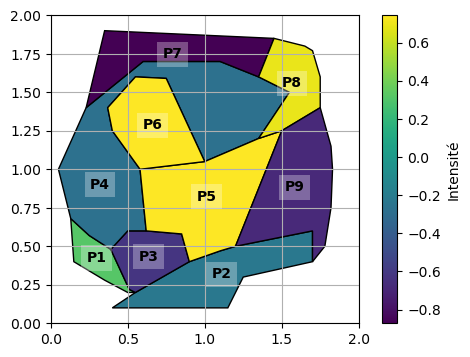

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from matplotlib.colors import Normalize

# Polygones dans [0,2]²
polygons = [
    Polygon([(0.5,0.2), (0.55,0.2), (0.51,0.22), (0.39,0.48), (0.25,0.57), (0.13,0.68), (0.15,0.4), (0.35,0.28)]),
    Polygon([(0.4,0.1), (1.15,0.1), (1.25,0.3), (1.7,0.4), (1.7,0.6), (1.2,0.5), (1.1,0.47), (0.9,0.4), (0.55,0.2)]),
    Polygon([(0.55,0.2), (0.9,0.4), (0.85,0.58), (0.62,0.6), (0.5,0.6), (0.39,0.48), (0.51,0.22), (0.55,0.2)]),
    Polygon([(0.13,0.68), (0.25,0.57), (0.39,0.48), (0.5,0.6), (0.62,0.6), (0.58,1.0), (0.4,1.25), (0.37,1.4), (0.55,1.6), 
             (0.75,1.59), (1.0,1.05), (1.35,1.2), (1.55,1.5), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4), (0.05,1.0)]),
    Polygon([(0.62,0.6), (0.85,0.58), (0.9,0.4), (1.1,0.47), (1.2,0.5), (1.5,1.25), (1.35,1.2), (1.0,1.05), (0.58,1.0)]),
    Polygon([(0.58,1.0), (1.0,1.05), (0.75,1.59), (0.55,1.6), (0.37,1.4), (0.4,1.25)]),
    Polygon([(0.23,1.4), (0.35,1.9), (1.45,1.85), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4)]),
    Polygon([(1.45,1.85), (1.35,1.6), (1.55,1.5), (1.35,1.2), (1.5,1.25), (1.75,1.4), (1.75,1.6), (1.7,1.77), (1.65,1.80)]),
    Polygon([(1.5,1.25), (1.2,0.5), (1.7,0.6), (1.7,0.4), (1.78,0.5), (1.82,0.75), (1.83,1.0), (1.82,1.15), (1.75,1.4)])
]

# Intensités (poids de zone)
#zone_weights = np.array([0.05, 0.05, 0.25, 0.01, 0.1, 0.14, 0.14, 0.01, 0.25]) 
zone_weights = np.random.normal(loc=0.0, scale=1.0, size=9)
cmap = plt.cm.viridis
norm = Normalize(vmin=zone_weights.min(), vmax=zone_weights.max())

# Calcul des aires
areas = np.array([poly.area for poly in polygons])
for i, area in enumerate(areas, 1):
    print(f"Aiire du polygone P{i} : {area:.4f}")


# =========================================== Affichage ===========================================
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for i, (poly, intensity) in enumerate(zip(polygons, zone_weights), start=1):
    color = cmap(norm(intensity))
    patch = plt.Polygon(list(poly.exterior.coords), facecolor=color, edgecolor='black')
    ax.add_patch(patch)

    # Position du label
    if i == 4:
        label_x, label_y = 0.32, 0.9  # Coordonnées choisies manuellement pour P4
    else:
        centroid = poly.centroid
        label_x, label_y = centroid.x, centroid.y

    ax.text(label_x, label_y, f'P{i}', color='black', weight='bold',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))

# Colorbar et finalisation
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label="Intensité")
#plt.title("\nZonage sismotectonique - Cas jouet\n")
plt.grid(True)
plt.show()
#fig.savefig("figure_zonage_cas_jouet.png") 



(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x326c27ef0>)

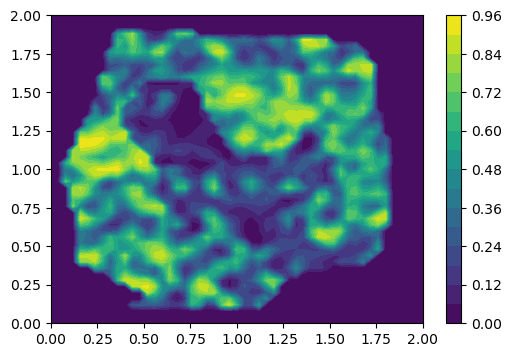

In [9]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely.prepared import prep

polygons = [
    Polygon([(0.5,0.2), (0.55,0.2), (0.51,0.22), (0.39,0.48), (0.25,0.57), (0.13,0.68), (0.15,0.4), (0.35,0.28)]),
    Polygon([(0.4,0.1), (1.15,0.1), (1.25,0.3), (1.7,0.4), (1.7,0.6), (1.2,0.5), (1.1,0.47), (0.9,0.4), (0.55,0.2)]),
    Polygon([(0.55,0.2), (0.9,0.4), (0.85,0.58), (0.62,0.6), (0.5,0.6), (0.39,0.48), (0.51,0.22), (0.55,0.2)]),
    Polygon([(0.13,0.68), (0.25,0.57), (0.39,0.48), (0.5,0.6), (0.62,0.6), (0.58,1.0), (0.4,1.25), (0.37,1.4), (0.55,1.6), 
             (0.75,1.59), (1.0,1.05), (1.35,1.2), (1.55,1.5), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4), (0.05,1.0)]),
    Polygon([(0.62,0.6), (0.85,0.58), (0.9,0.4), (1.1,0.47), (1.2,0.5), (1.5,1.25), (1.35,1.2), (1.0,1.05), (0.58,1.0)]),
    Polygon([(0.58,1.0), (1.0,1.05), (0.75,1.59), (0.55,1.6), (0.37,1.4), (0.4,1.25)]),
    Polygon([(0.23,1.4), (0.35,1.9), (1.45,1.85), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4)]),
    Polygon([(1.45,1.85), (1.35,1.6), (1.55,1.5), (1.35,1.2), (1.5,1.25), (1.75,1.4), (1.75,1.6), (1.7,1.77), (1.65,1.80)]),
    Polygon([(1.5,1.25), (1.2,0.5), (1.7,0.6), (1.7,0.4), (1.78,0.5), (1.82,0.75), (1.83,1.0), (1.82,1.15), (1.75,1.4)])
]
#zone_weights = np.array([0.05, 0.05, 0.25, 0.01, 0.1, 0.14, 0.14, 0.01, 0.25]) 
zone_weights = np.random.normal(loc=0.0, scale=1.0, size=9)

Zones = [(prep(p), float(w)) for p, w in zip(polygons, zone_weights)]

mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))

def tend(X):
    x, y = float(X[0]), float(X[1])
    pt = Point(x, y)
    for P, w in Zones:
        if P.covers(pt):
            #return [-np.log( (max(abs(zone_weights)) /abs(w))-1 )]  
            return [w]           
    return [-np.inf]

f = ot.PythonFunction(2, 1, tend)
fTrend = ot.TrendTransform(f, mesh)
cov = ot.SquaredExponential([0.05, 0.05], [1.0])
X = ot.GaussianProcess(fTrend, cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

field_f = process.getRealization()
plot_field(field_f)
#fig.savefig("figure_gp_zonage.png") 


In [10]:
field_f

class=Field name=Unnamed description=[v0,v1,y0] implementation=class=FieldImplementation name=Unnamed mesh=class=Mesh name=Unnamed dimension=2 vertices=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2601 dimension=2 data=[[0,0],[0.04,0],[0.08,0],...,[1.92,2],[1.96,2],[2,2]] simplices=[[0,1,51],[1,52,51],[1,2,52],[2,53,52],[2,3,53],[3,54,53],[3,4,54],[4,55,54],[4,5,55],[5,56,55],[5,6,56],[6,57,56],[6,7,57],[7,58,57],[7,8,58],[8,59,58],[8,9,59],[9,60,59],[9,10,60],[10,61,60],[10,11,61],[11,62,61],[11,12,62],[12,63,62],[12,13,63],[13,64,63],[13,14,64],[14,65,64],[14,15,65],[15,66,65],[15,16,66],[16,67,66],[16,17,67],[17,68,67],[17,18,68],[18,69,68],[18,19,69],[19,70,69],[19,20,70],[20,71,70],[20,21,71],[21,72,71],[21,22,72],[22,73,72],[22,23,73],[23,74,73],[23,24,74],[24,75,74],[24,25,75],[25,76,75],[25,26,76],[26,77,76],[26,27,77],[27,78,77],[27,28,78],[28,79,78],[28,29,79],[29,80,79],[29,30,80],[30,81,80],[30,31,81],[31,82,81],[31,32,82],[32,83,82],[32,33,83],[33,84,83],[33,34,84],[34,85,84],[34,35,85],[35,86,85],[35,36,86],[36,87,86],[36,37,87],[37,88,87],[37,38,88],[38,89,88],[38,39,89],[39,90,89],[39,40,90],[40,91,90],[40,41,91],[41,92,91],[41,42,92],[42,93,92],[42,43,93],[43,94,93],[43,44,94],[44,95,94],[44,45,95],[45,96,95],[45,46,96],[46,97,96],[46,47,97],[47,98,97],[47,48,98],[48,99,98],[48,49,99],[49,100,99],[49,50,100],[50,101,100],[51,52,102],[52,103,102],[52,53,103],[53,104,103],[53,54,104],[54,105,104],[54,55,105],[55,106,105],[55,56,106],[56,107,106],[56,57,107],[57,108,107],[57,58,108],[58,109,108],[58,59,109],[59,110,109],[59,60,110],[60,111,110],[60,61,111],[61,112,111],[61,62,112],[62,113,112],[62,63,113],[63,114,113],[63,64,114],[64,115,114],[64,65,115],[65,116,115],[65,66,116],[66,117,116],[66,67,117],[67,118,117],[67,68,118],[68,119,118],[68,69,119],[69,120,119],[69,70,120],[70,121,120],[70,71,121],[71,122,121],[71,72,122],[72,123,122],[72,73,123],[73,124,123],[73,74,124],[74,125,124],[74,75,125],[75,126,125],[75,76,126],[76,127,126],[76,77,127],[77,128,127],[77,78,128],[78,129,128],[78,79,129],[79,130,129],[79,80,130],[80,131,130],[80,81,131],[81,132,131],[81,82,132],[82,133,132],[82,83,133],[83,134,133],[83,84,134],[84,135,134],[84,85,135],[85,136,135],[85,86,136],[86,137,136],[86,87,137],[87,138,137],[87,88,138],[88,139,138],[88,89,139],[89,140,139],[89,90,140],[90,141,140],[90,91,141],[91,142,141],[91,92,142],[92,143,142],[92,93,143],[93,144,143],[93,94,144],[94,145,144],[94,95,145],[95,146,145],[95,96,146],[96,147,146],[96,97,147],[97,148,147],[97,98,148],[98,149,148],[98,99,149],[99,150,149],[99,100,150],[100,151,150],[100,101,151],[101,152,151],[102,103,153],[103,154,153],[103,104,154],[104,155,154],[104,105,155],[105,156,155],[105,106,156],[106,157,156],[106,107,157],[107,158,157],[107,108,158],[108,159,158],[108,109,159],[109,160,159],[109,110,160],[110,161,160],[110,111,161],[111,162,161],[111,112,162],[112,163,162],[112,113,163],[113,164,163],[113,114,164],[114,165,164],[114,115,165],[115,166,165],[115,116,166],[116,167,166],[116,117,167],[117,168,167],[117,118,168],[118,169,168],[118,119,169],[119,170,169],[119,120,170],[120,171,170],[120,121,171],[121,172,171],[121,122,172],[122,173,172],[122,123,173],[123,174,173],[123,124,174],[124,175,174],[124,125,175],[125,176,175],[125,126,176],[126,177,176],[126,127,177],[127,178,177],[127,128,178],[128,179,178],[128,129,179],[129,180,179],[129,130,180],[130,181,180],[130,131,181],[131,182,181],[131,132,182],[132,183,182],[132,133,183],[133,184,183],[133,134,184],[134,185,184],[134,135,185],[135,186,185],[135,136,186],[136,187,186],[136,137,187],[137,188,187],[137,138,188],[138,189,188],[138,139,189],[139,190,189],[139,140,190],[140,191,190],[140,141,191],[141,192,191],[141,142,192],[142,193,192],[142,143,193],[143,194,193],[143,144,194],[144,195,194],[144,145,195],[145,196,195],[145,146,196],[146,197,196],[146,147,197],[147,198,197],[147,148,198],[148,199,198],[148,149,199],[149,200,199],[149,150,200],[150,201,200],

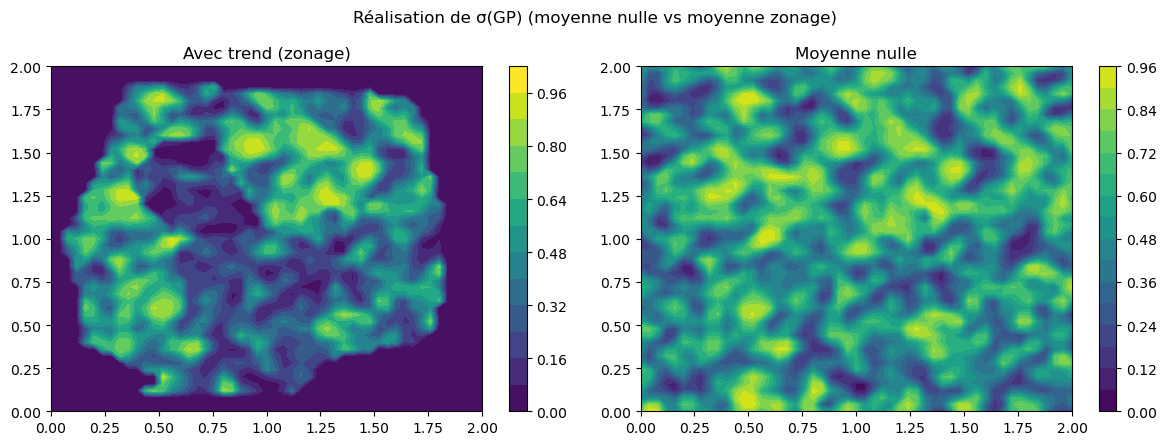

In [11]:
# Avec trend (zonage)
X_trend = ot.GaussianProcess(fTrend, cov, mesh)
process_trend = ot.CompositeProcess(field_function, X_trend)

# Moyenne nulle
X_zero = ot.GaussianProcess(cov, mesh)
process_zero = ot.CompositeProcess(field_function, X_zero)

# Noyau fixe pour comparaison 
seed = 123
ot.RandomGenerator.SetSeed(seed)
field_trend = process_trend.getRealization()
ot.RandomGenerator.SetSeed(seed)
field_zero  = process_zero.getRealization()


fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
vmin, vmax = 0.0, 1.0

plot_field(field_trend, mode="subplot", ax=axes[0],
           title="Avec trend (zonage)", vmin=vmin, vmax=vmax, add_colorbar=True)

plot_field(field_zero,  mode="subplot", ax=axes[1],
           title="Moyenne nulle", vmin=vmin, vmax=vmax, add_colorbar=True)

fig.suptitle("Réalisation de σ(GP) (moyenne nulle vs moyenne zonage)")
plt.tight_layout()
plt.show()


# SGCP informatif Gibbs Sampler avec OpenTURNS

In [6]:
import numpy as np
from shapely.geometry import Point
from polyagamma import random_polyagamma
import openturns as ot
from shapely.geometry import Point as ShapelyPoint


class GPETAS_GibbsSampler:
    """
    
    """
    def __init__(
        self,
        X_bounds,
        Y_bounds,
        T,
        Areas,
        nu,
        a_mu,
        b_mu,
        jitter=1e-2,
        rng_seed=None,
    ):
        self.X_bounds = tuple(X_bounds)
        self.Y_bounds = tuple(Y_bounds)
        self.T = T
        self.Areas = Areas
        self.nu = ot.Point(nu)
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.jitter = jitter

        self.rng = ot.RandomGenerator.SetSeed(rng_seed)

        self.areas = [a[0] for a in self.Areas]
        self.epsilons = [a[1] for a in self.Areas]
        self.J = len(self.areas)

    # ==========================================================================
    # ------------------------------- Outillage --------------------------------
    # ==========================================================================

    @staticmethod
    def sigma(z):
        """
        
        """
        z_array = np.array(z)
        return ot.Point(1.0 / (1.0 + np.exp(-z_array)))
    
    @staticmethod
    def compute_kernel_matrix(self, D_xy):
        """
        
        """
        nu0, nu1, nu2 = map(float, self.nu)
        
        ### Convertir en Sample si jamais c'est nécessaire
        if not isinstance(D_xy, ot.Sample):
            D_xy_sample = ot.Sample(np.asarray(D_xy, dtype=float).tolist())
        else:
            D_xy_sample = D_xy

        kernel = ot.SquaredExponential([nu1, nu2], [nu0])
        K = kernel.discretize(D_xy_sample)
        
        return K
    
    def compute_kernel_matrices(self, XY_data, XY_new):
        """
        
        """
        nu0, nu1, nu2 = map(float, self.nu)
        
        N_new = XY_new.getSize()
        N_data = XY_data.getSize()
        
        kernel = ot.SquaredExponential([nu1, nu2], [nu0])
        
        XY_all = ot.Sample(N_data + N_new, 2)
        for i in range(N_data):
            XY_all[i, 0] = XY_data[i, 0]
            XY_all[i, 1] = XY_data[i, 1]
        for i in range(N_new):
            XY_all[N_data + i, 0] = XY_new[i, 0]
            XY_all[N_data + i, 1] = XY_new[i, 1]
        
        K_all = kernel.discretize(XY_all)
        
        # K_data_data : lignes [0:N_data], colonnes [0:N_data]
        K_data_data = ot.CovarianceMatrix(N_data)
        for i in range(N_data):
            for j in range(i, N_data): 
                K_data_data[i, j] = K_all[i, j]
        
        # K_new_data : lignes [N_data:N_data+N_new], colonnes [0:N_data]
        K_new_data = ot.Matrix(N_new, N_data)
        for i in range(N_new):
            for j in range(N_data):
                K_new_data[i, j] = K_all[N_data + i, j]
        
        # K_new_new : lignes [N_data:N_data+N_new], colonnes [N_data:N_data+N_new]
        K_new_new = ot.CovarianceMatrix(N_new)
        for i in range(N_new):
            for j in range(i, N_new): 
                K_new_new[i, j] = K_all[N_data + i, N_data + j]
        
        return K_data_data, K_new_data, K_new_new

    def compute_U_from_areas(self, D_xy):
        """
        
        """
        ### Convertir en Sample si jamais c'est nécessaire
        if not isinstance(D_xy, ot.Sample):
            D_xy_sample = ot.Sample(np.asarray(D_xy, dtype=float).tolist())
        else:
            D_xy_sample = D_xy
            
        n = D_xy_sample.getSize()
        U = ot.Sample(n, self.J)
        
        for k in range(n):
            pt = D_xy_sample[k]
            pt_shapely = ShapelyPoint(pt[0], pt[1])
            
            for j, P in enumerate(self.areas):
                if P.covers(pt_shapely):
                    U[k, j] = 1.0
                    break 
            
        return U
    
    def sample_candidats(self, N):
        """
        
        """
        xmin, xmax = self.X_bounds
        ymin, ymax = self.Y_bounds
        marginal_x = ot.Uniform(xmin, xmax)
        marginal_y = ot.Uniform(ymin, ymax)
        distribution = ot.ComposedDistribution([marginal_x, marginal_y])
        
        return distribution.getSample(int(N))
    
    
    
    # =================================================================================
    # -------------------------- Posteriors conditionnelles ---------------------------
    # =================================================================================

    def update_mu_tilde(self, Z, Pi_S):
        """
        
        """
        xmin, xmax = self.X_bounds
        ymin, ymax = self.Y_bounds
        
        N_0 = sum(1 for z in Z if z == 0.0)         # Faire en sorte que Z soit sous le format Point
        N_Pi = Pi_S.getSize()                       # Faire en sorte que Pi_S soit sous le format Sample
        
        a_post = self.a_mu + N_0 + N_Pi
        b_post = self.b_mu + self.T * (xmax - xmin) * (ymax - ymin)
        
        mu_tilde = ot.Gamma(a_post, b_post, 0.0).getRealization()[0]
        
        return mu_tilde
    
    def update_epsilons(self, f_Df, K_ff, U):
        """

        """
        n = K_ff.getDimension()

        # Nugget sur K_ff avant inverse (stabilité) ; Vient de ChatGPT, à bien comprendre pcq va être réutilisé plusieurs fois
        K_cov_reg = ot.CovarianceMatrix(K_ff)
        diag_mean = sum(float(K_cov_reg[i, i]) for i in range(n)) / float(max(1, n))
        nugget = max(float(self.jitter), 1e-8 * max(1.0, diag_mean))
        for i in range(n):
            K_cov_reg[i, i] += nugget

        K_inv = K_cov_reg.inverse()

        # U -> Matrix
        if isinstance(U, ot.Matrix):
            U_mat = U
        elif isinstance(U, ot.Sample):
            U_mat = ot.Matrix(U)
        else:
            U_mat = ot.Matrix(np.asarray(U, float).tolist())

        U_T = U_mat.transpose()

        A_mat = U_T * K_inv * U_mat + ot.IdentityMatrix(self.J)
        A_array = np.array(A_mat)
        A_array = 0.5 * (A_array + A_array.T)
        A_array += float(self.jitter) * np.eye(self.J)

        A_cov = ot.CovarianceMatrix(A_array.tolist())
        Sigma_sym = A_cov.inverse()
        Sigma = ot.CovarianceMatrix(np.array(Sigma_sym).tolist())

        rhs_raw = U_T * (K_inv * f_Df) 
        if isinstance(rhs_raw, ot.Point):
            rhs = rhs_raw
        else:
            rhs = ot.Point([float(rhs_raw[i, 0]) for i in range(self.J)])

        mu_raw = Sigma * rhs  
        if isinstance(mu_raw, ot.Point):
            mu = mu_raw
        else:
            mu = ot.Point([float(mu_raw[i, 0]) for i in range(self.J)])

        distribution = ot.Normal(mu, Sigma)
        epsilons = distribution.getRealization()
        return epsilons

    def update_f(self, x, y, eps, Z, omega_D0, Pi_S):
        """
        
        """

        # 1) Indices des points D0
        idx = [i for i in range(len(Z)) if Z[i] == 0.0]
        N_0 = len(idx)

        D_0 = ot.Sample(N_0, 2)
        omega_D_0 = ot.Point(N_0)
        for k, i in enumerate(idx):
            D_0[k, 0] = x[i]
            D_0[k, 1] = y[i]
            omega_D_0[k] = omega_D0[i]

        # 2) Pi_S -> PiS(x,y) + omega_Pi
        N_Pi = Pi_S.getSize()
        if N_Pi > 0:
            PiS = ot.Sample(N_Pi, 2)
            omega_Pi = ot.Point(N_Pi)
            for i in range(N_Pi):
                PiS[i, 0] = Pi_S[i, 0]
                PiS[i, 1] = Pi_S[i, 1]
                omega_Pi[i] = Pi_S[i, 2]
        else:
            PiS = ot.Sample(0, 2)
            omega_Pi = ot.Point(0)

        # 3) D_f = D0 U PiS
        N_f = N_0 + N_Pi
        D_f = ot.Sample(N_f, 2)
        for i in range(N_0):
            D_f[i, 0] = D_0[i, 0]
            D_f[i, 1] = D_0[i, 1]
        for i in range(N_Pi):
            D_f[N_0 + i, 0] = PiS[i, 0]
            D_f[N_0 + i, 1] = PiS[i, 1]

        # 4) U et m_f = U * eps
        U = self.compute_U_from_areas(D_f)     
        U_mat = ot.Matrix(U)                  

        if not isinstance(eps, ot.Point):
            eps = ot.Point(eps)
        J = eps.getDimension()
        eps_col = ot.Matrix([[float(eps[j])] for j in range(J)])    

        m_f_mat = U_mat * eps_col    
        m_f = ot.Point([float(m_f_mat[i, 0]) for i in range(N_f)])

        # 5) K_ff + nugget, puis inversion
        K_ff = self.compute_kernel_matrix(self, D_f) 

        K_ff_reg = ot.CovarianceMatrix(K_ff)
        diag_mean = sum(float(K_ff_reg[i, i]) for i in range(N_f)) / float(max(1, N_f))
        nugget = max(float(self.jitter), 1e-8 * max(1.0, diag_mean))
        for i in range(N_f):
            K_ff_reg[i, i] += nugget

        K_inv = K_ff_reg.inverse()

        # 6) Omega diag
        omega_diag = ot.Point(N_f)
        for i in range(N_0):
            omega_diag[i] = omega_D_0[i]
        for i in range(N_Pi):
            omega_diag[N_0 + i] = omega_Pi[i]

        Omega = ot.CovarianceMatrix(N_f)
        for i in range(N_f):
            Omega[i, i] = omega_diag[i]

        # u = [0.5,...,0.5,-0.5,...,-0.5]
        u = ot.Point(N_f)
        for i in range(N_0):
            u[i] = 0.5
        for i in range(N_Pi):
            u[N_0 + i] = -0.5

        # 7) Sigma_f et mu_f
        A_mat = Omega + K_inv
        A_array = np.array(A_mat)
        A_array = 0.5 * (A_array + A_array.T)
        A = ot.CovarianceMatrix(A_array.tolist())

        Sigma_f_sym = A.inverse() 
        Sigma_f = ot.CovarianceMatrix(np.array(Sigma_f_sym).tolist()) 

        temp = K_inv * m_f + u
        mu_f_raw = Sigma_f * temp
        if isinstance(mu_f_raw, ot.Point):
            mu_f = mu_f_raw
        else:
            mu_f = ot.Point([float(mu_f_raw[i, 0]) for i in range(N_f)])

        f_new = ot.Normal(mu_f, Sigma_f).getRealization()
        return f_new, D_f, U, K_ff_reg, m_f

    def sample_Pi_S(self, mu_tilde, T, X_data, Y_data, f_data, eps):
        """
        
        """

        N = X_data.getSize()
        area = (self.X_bounds[1] - self.X_bounds[0]) * (self.Y_bounds[1] - self.Y_bounds[0])
        mean_cand = mu_tilde * T * area

        # Pour éviter les lambdas gigantesques
        mean_cand = float(mean_cand)
        mean_cand = min(mean_cand, 1e2)

        N_cand = int(np.random.poisson(mean_cand))

        # Cap dur (sinon GP impossible à inverser)
        N_cand = min(N_cand, 1000)

        if N_cand == 0:
            return ot.Sample(0, 3)

        # 1) Candidates + XY_data
        XY_cand = self.sample_candidats(N_cand)
        XY_data = ot.Sample([[X_data[i], Y_data[i]] for i in range(N)])

        # 2) m_data, m_cand
        U_data = self.compute_U_from_areas(XY_data)
        U_cand = self.compute_U_from_areas(XY_cand)

        U_data_mat = ot.Matrix(U_data)
        U_cand_mat = ot.Matrix(U_cand)

        if not isinstance(eps, ot.Point):
            eps = ot.Point(eps)
        J = eps.getDimension()
        eps_col = ot.Matrix([[float(eps[j])] for j in range(J)])  # (J×1)

        m_data_mat = U_data_mat * eps_col  # (N×1)
        m_cand_mat = U_cand_mat * eps_col  # (N_cand×1)

        m_data = ot.Point([float(m_data_mat[i, 0]) for i in range(N)])
        m_cand = ot.Point([float(m_cand_mat[i, 0]) for i in range(N_cand)])

        # 3) Kernels
        K_dd, K_star_d, K_star_star = self.compute_kernel_matrices(XY_data, XY_cand)

        # 4) Régulariser K_dd avant inversion
        K_dd_reg = ot.CovarianceMatrix(K_dd)
        diag_mean_dd = sum(float(K_dd_reg[i, i]) for i in range(N)) / float(max(1, N))
        nugget_dd = max(float(self.jitter), 1e-8 * max(1.0, diag_mean_dd))
        for i in range(N):
            K_dd_reg[i, i] += nugget_dd

        K_inv = K_dd_reg.inverse()

        # 5) Conditionnel: mu_star et Sigma_star
        f_data_point = f_data if isinstance(f_data, ot.Point) else ot.Point(f_data)
        delta = f_data_point - m_data

        k_term_raw = K_star_d * (K_inv * delta)
        if isinstance(k_term_raw, ot.Point):
            k_term = k_term_raw
        else:
            # cas Matrix (N_cand×1)
            k_term = ot.Point([float(k_term_raw[i, 0]) for i in range(N_cand)])

        mu_star = m_cand + k_term  # Point(N_cand)

        Sigma_star_mat = K_star_star - K_star_d * (K_inv * K_star_d.transpose())

        Sigma_array = np.array(Sigma_star_mat)
        Sigma_array = 0.5 * (Sigma_array + Sigma_array.T)

        diag_mean = float(np.mean(np.diag(Sigma_array))) if Sigma_array.size else 1.0
        jitter = max(float(self.jitter), 1e-8 * max(1.0, diag_mean))
        Sigma_array += jitter * np.eye(N_cand)

        Sigma_star = ot.CovarianceMatrix(Sigma_array.tolist())

        f_star = ot.Normal(mu_star, Sigma_star).getRealization()

        # 6) Thinning
        accept_probs = self.sigma(-f_star)
        Uu = ot.Uniform(0.0, 1.0).getSample(N_cand)

        mask = [i for i in range(N_cand) if Uu[i, 0] < accept_probs[i]]
        if len(mask) == 0:
            return ot.Sample(0, 3)

        XY_acc = ot.Sample(len(mask), 2)
        f_acc = np.zeros(len(mask))
        for k, i in enumerate(mask):
            XY_acc[k, 0] = XY_cand[i, 0]
            XY_acc[k, 1] = XY_cand[i, 1]
            f_acc[k] = f_star[i]

        omega_acc = random_polyagamma(1.0, f_acc)

        n_acc = len(omega_acc)
        Pi_S = ot.Sample(n_acc, 3)
        for i in range(n_acc):
            Pi_S[i, 0] = XY_acc[i, 0]
            Pi_S[i, 1] = XY_acc[i, 1]
            Pi_S[i, 2] = omega_acc[i]

        return Pi_S


    # =================================================================================
    # --------------------------------- Run du Gibbs ----------------------------------
    # =================================================================================

    def run(self, t, x, y, eps_init, mu_init, n_iter=1000, store_f_data=True, verbose=True, verbose_every=100):
        """

        """
        # Vérif des types
        if not isinstance(t, ot.Point):
            t = ot.Point(t)
        if not isinstance(x, ot.Point):
            x = ot.Point(x)
        if not isinstance(y, ot.Point):
            y = ot.Point(y)
        if not isinstance(eps_init, ot.Point):
            eps_init = ot.Point(eps_init)
        
        N = len(t)
        T = float(max(t))
        
        Z = ot.Point([0.0] * N)      # ETAS = 0
        
        # Initialisation
        eps = ot.Point(eps_init)
        mu_tilde = float(mu_init)
        
        # f_data initial
        XY_data = ot.Sample([[x[i], y[i]] for i in range(N)])
        U_data = self.compute_U_from_areas(XY_data)
        f_data = ot.Point(np.array(U_data) @ np.array(eps))
        
        # Stockage
        mu_chain = np.zeros(n_iter)
        eps_chain = np.zeros((n_iter, self.J))
        nPi_chain = np.zeros(n_iter, dtype=int)
        fdata_chain = np.zeros((n_iter, N)) if store_f_data else None
        
        for it in range(n_iter):
            # 1) omega_D0 | f_data
            omega_D0 = ot.Point(random_polyagamma(1.0, np.array(f_data)))
            
            # 2) Pi_S (retrun ot.Sample)
            Pi_S = self.sample_Pi_S(mu_tilde, T, x, y, f_data, eps)
            
            # 3) f sur D_f (return ot.Point)
            f_Df, D_f_xy, U_Df, K_ff, m_f = self.update_f(
                x, y, eps, Z, omega_D0, Pi_S
            )
            
            # Extraire f_data (N premiers éléments)
            f_data = ot.Point([f_Df[i] for i in range(N)])
            
            # 4) eps (retrun ot.Point)
            eps = self.update_epsilons(f_Df, K_ff, U_Df)
            
            # 5) mu_tilde (return float)
            mu_tilde = self.update_mu_tilde(Z, Pi_S)
            
            # Affichage
            if verbose and (it % verbose_every == 0 or it == n_iter - 1):
                eps_arr = np.array(eps)
                f_data_arr = np.array(f_data)
                n_pi = Pi_S.getSize()
                
                print(
                    f"[Gibbs it {it:4d}] "
                    f"mu_tilde={mu_tilde:.4f} | "
                    f"|Pi|={n_pi:4d} | "
                    f"eps_mean={eps_arr.mean():+.3f} | "
                    f"eps_std={eps_arr.std():.3f} | "
                    f"f_data[min,max]=[{f_data_arr.min():+.2f}, {f_data_arr.max():+.2f}]"
                )
            
            # Stockage 
            mu_chain[it] = mu_tilde
            eps_chain[it, :] = np.array(eps)
            nPi_chain[it] = Pi_S.getSize()
            if store_f_data:
                fdata_chain[it, :] = np.array(f_data)
        
        return {
            "mu_tilde": mu_chain,
            "eps": eps_chain,
            "nPi": nPi_chain,
            "f_data": fdata_chain,
            "last_state": {
                "mu_tilde": mu_tilde,
                "eps": eps,               
                "nu": list(self.nu)
            },
        }

### Test du Gibbs

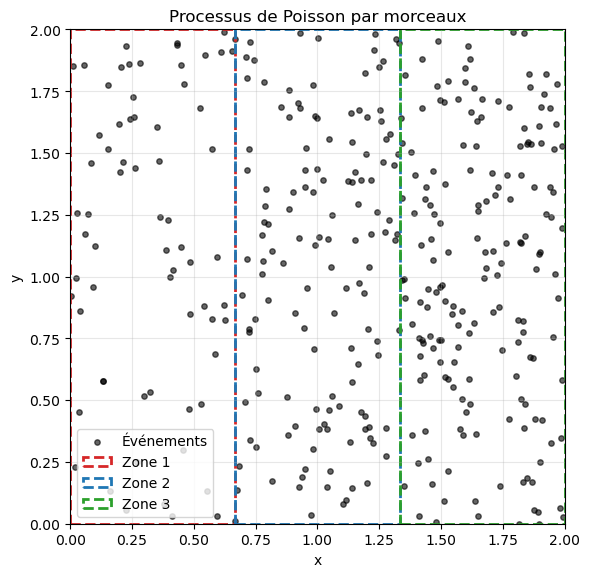

In [7]:
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def generate_data(
    seed=0,
    X_bounds=(0.0, 2.0),
    Y_bounds=(0.0, 2.0),
    T=10.0,
    mu_tilde=8.0,
    epsilons=(-0.5, 0.0, 0.5),         
):
    rng = np.random.default_rng(seed)

    xmin, xmax = X_bounds
    ymin, ymax = Y_bounds
    x1 = xmin + (xmax - xmin) / 3.0
    x2 = xmin + 2.0 * (xmax - xmin) / 3.0

    zone1 = box(xmin, ymin, x1, ymax)
    zone2 = box(x1,  ymin, x2, ymax)
    zone3 = box(x2,  ymin, xmax, ymax)
    zones = [zone1, zone2, zone3]

    all_t, all_x, all_y = [], [], []

    for zone, eps in zip(zones, epsilons):
        mu = float(mu_tilde) * float(np.exp(eps))
        A = float(zone.area)
        mean_n = mu * float(T) * A
        n = int(rng.poisson(mean_n))

        if n == 0:
            continue

        z_xmin, z_ymin, z_xmax, z_ymax = zone.bounds
        xs = rng.uniform(z_xmin, z_xmax, n)
        ys = rng.uniform(z_ymin, z_ymax, n)
        ts = rng.uniform(0.0, T, n)

        all_x.append(xs)
        all_y.append(ys)
        all_t.append(ts)

    x = np.concatenate(all_x)
    y = np.concatenate(all_y)
    t = np.concatenate(all_t)
    
    # Conversion vers OpenTURNS
    t = ot.Point(t.tolist())
    x = ot.Point(x.tolist())
    y = ot.Point(y.tolist())

    return t, x, y, zones, X_bounds, Y_bounds, T, epsilons, mu_tilde

def plot_points_and_zones(x, y, zones, X_bounds, Y_bounds, title="Points simulés"):
    """
    
    """

    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    fig, ax = plt.subplots(figsize=(6, 7))

    ax.scatter(x, y, s=15, alpha=0.6, color="black", label="Événements")
    colors = ["tab:red", "tab:blue", "tab:green"]
    for i, (zone, color) in enumerate(zip(zones, colors)):
        xmin, ymin, xmax, ymax = zone.bounds
        rect = Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=color,
            linewidth=2,
            linestyle="--",
            label=f"Zone {i+1}"
        )
        ax.add_patch(rect)

    ax.set_xlim(X_bounds)
    ax.set_ylim(Y_bounds)
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

t, x, y, zones, X_bounds, Y_bounds, T, true_eps, base_lams = generate_data()

plot_points_and_zones(
    x=x,
    y=y,
    zones=zones,
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    title="Processus de Poisson par morceaux"
)


In [8]:
def setup_sampler_zones(zones, X_bounds, Y_bounds, T, rng_seed=123):
    Areas = [(z, 0.0) for z in zones]     # Intensités des zones à 0.0

    sampler = GPETAS_GibbsSampler(
        X_bounds=X_bounds,
        Y_bounds=Y_bounds,
        T=T,
        Areas=Areas,
        nu=[1.0, 0.25, 0.25],
        a_mu=1.0,
        b_mu=1.0,
        jitter=1e-4,
        rng_seed=rng_seed,
    )
    return sampler



def test_gibbs(seed_data=0):
    print("\n===== TEST (3 zones + PorcessusPoisson par zone) =====\n")

    t, x, y, zones, X_bounds, Y_bounds, T, true_eps, true_mutilde = generate_data(
        seed=seed_data,
        X_bounds=(0.0, 1.0),
        Y_bounds=(0.0, 1.0),
        T=10.0,
        mu_tilde=8.0,
        epsilons=(-0.5, 0.0, 0.5),
    )

    N = len(t)
    print(f"Nombre d'événements simulés: N={N}")
    print(f"True eps: {true_eps}")
    print(f"True mu_tilde: {true_mutilde}\n")

    sampler = setup_sampler_zones(zones, X_bounds, Y_bounds, T, rng_seed=123)

    eps_init = ot.Point([0.0, 0.0, 0.0])
    mu_init = 7.0

    results = sampler.run(
        t=t,
        x=x,
        y=y,
        eps_init=eps_init,
        mu_init=mu_init,
        n_iter=1000,            
        store_f_data=False,
        verbose=True,
        verbose_every=10
    )

    print("\n Gibbs terminé")
    print("Dernier état:")
    print("  mu_tilde =", results["last_state"]["mu_tilde"])
    print("  eps      =", results["last_state"]["eps"])
    return results


if __name__ == "__main__":
    test_gibbs(seed_data=0)



===== TEST (3 zones + PorcessusPoisson par zone) =====

Nombre d'événements simulés: N=95
True eps: (-0.5, 0.0, 0.5)
True mu_tilde: 8.0

[Gibbs it    0] mu_tilde=12.1696 | |Pi|=  35 | eps_mean=+0.074 | eps_std=0.008 | f_data[min,max]=[-0.98, +2.35]
[Gibbs it   10] mu_tilde=12.1449 | |Pi|=  33 | eps_mean=+0.417 | eps_std=0.020 | f_data[min,max]=[-0.19, +2.36]
[Gibbs it   20] mu_tilde=10.0360 | |Pi|=  12 | eps_mean=+0.914 | eps_std=0.005 | f_data[min,max]=[-0.07, +2.74]
[Gibbs it   30] mu_tilde=11.5590 | |Pi|=  27 | eps_mean=+0.455 | eps_std=0.092 | f_data[min,max]=[-0.77, +3.09]
[Gibbs it   40] mu_tilde=10.3548 | |Pi|=  40 | eps_mean=+0.765 | eps_std=0.088 | f_data[min,max]=[-1.33, +3.37]
[Gibbs it   50] mu_tilde=11.4113 | |Pi|=  34 | eps_mean=+0.681 | eps_std=0.070 | f_data[min,max]=[-0.77, +2.37]
[Gibbs it   60] mu_tilde=11.3504 | |Pi|=  29 | eps_mean=+0.756 | eps_std=0.042 | f_data[min,max]=[-1.03, +2.65]
[Gibbs it   70] mu_tilde=10.5465 | |Pi|=  31 | eps_mean=+0.231 | eps_std=0.007